# Predicting the Poverty Probability Index

Welcome to the companion notebook for my project on predicting the PPI.  The goal of this notebook is to summarize the work of the project, try a couple new angles, and make the analysis more accessible (rather than representing the whole project itself).  The data report in this repository should be considered the more complete presentation.  This notebook will make use of the scripts in this repository, either by coping some of the code or running the script directly.  

Predicting the Poverty Probability Index (PPI) from the data provided is a little weird.  The original data for the determination of the PPI is not present for this project, and much of the data that is available is boolean or categorical, while the PPI is itself a continuous probability.  Furthermore, there are issues with the dataset itself.  Out of 8 continuous (float) variables, 4 are mostly empty, and 2 are miscoded, and the remaining 2 correlate only weakly with the label.  The result is that accurate prediction of the PPI is not possible.

The first few cells import the packages and data.

In [96]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import warnings

warnings.filterwarnings("ignore", category = FutureWarning)

In [97]:
df = pd.read_csv('data/train_values.csv', index_col = 'row_id')
labels = pd.read_csv('data/train_labels.csv', index_col = 'row_id')
df = df.join(labels)

## Sparse and Uninformative Features

This cell cleans removes sparse features.  "Sparse features" are defined here as features that are mostly blank or null.  Here the standard for mostly null is 80% or more.

In [98]:
# Drop sparse columns.
s = {}
for column in df.columns:
    s[column] = df[column].isnull().sum()

s = pd.Series(s)
null_tolerance = round(len(df)*.2)
empties = list(s[s > null_tolerance].index)
df = df.drop(columns = empties)

# Drop emtpy rows
df.dropna(inplace = True) 

Many features here are not very informative.  This project defines the "informativeness" of a (discrete) feature as the maximum difference in average PPI values corresponding to its own values, in percentage points.  

For example, the cell below shows how the feature of being employed last year relates to PPI.  Surprisingly, whether someone was employed last year made almost no difference to their PPI: only 2 percentage points.

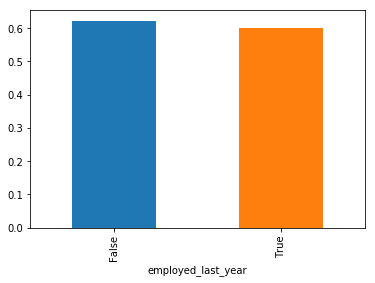

In [99]:
feature = 'employed_last_year'
s = df.groupby(feature).poverty_probability.mean()
s.plot.bar()

This cell removes uninformative features.  Besides floats, all these features will have a small number of possible values.  The criterion for informativeness here is min-max difference.  If the argument with the highest average PPI is barely higher than the lowest (5 percentage points or less), the feature is rejected.

In [100]:
# Drop uninformative columns
columns = df.columns[df.dtypes != 'float64']

drop_cols = []
for col in columns:
    s = df.groupby(col)['poverty_probability'].mean()
    if s.max() - s.min() < 0.05:
        drop_cols.append(col)

df = df.drop(columns = drop_cols)

## Recoding Features

Several features have the wrong data types.  One is "education_level."  This feature is coded as a float (shown below), but its description (and quartile values) suggest otherwise.

In [101]:
col = 'education_level'
df[col].describe()

count    12068.000000
mean         1.316291
std          0.903742
min          0.000000
25%          1.000000
50%          1.000000
75%          2.000000
max          3.000000
Name: education_level, dtype: float64

Attempting a scatter plot of PPI vs education_level shows a problem.

Text(0.5,1,'Education Level (A Float?)')

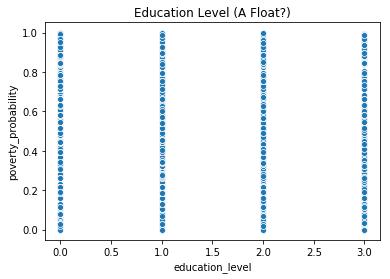

In [102]:
sns.scatterplot(x = 'education_level', y = 'poverty_probability', data = df)
plt.title('Education Level (A Float?)')

Clearly, this value is not really a float.  It is probably best to cast it as categorical.  The cell below recodes problematic floats.

In [103]:
'education_level', 'share_hh_income_provided'
col = 'education_level'
df[col] = df[col].astype(int).astype(str)
print(df[col].head())

col = 'share_hh_income_provided'
df[col] = df[col].astype(int)

row_id
0    1
2    1
4    1
5    1
6    1
Name: education_level, dtype: object


Some features coded as integers should be categorical instead.  One integer-type feature is a special case.  This is "num_formal_institutions_last_year".  This feature does not *correlate* with PPI.  Yet the feature is very *informative* about PPI.  

The value of PPI is not monotonic on these features.  To capture the information these features contain, they will be converted to categorical variables. 

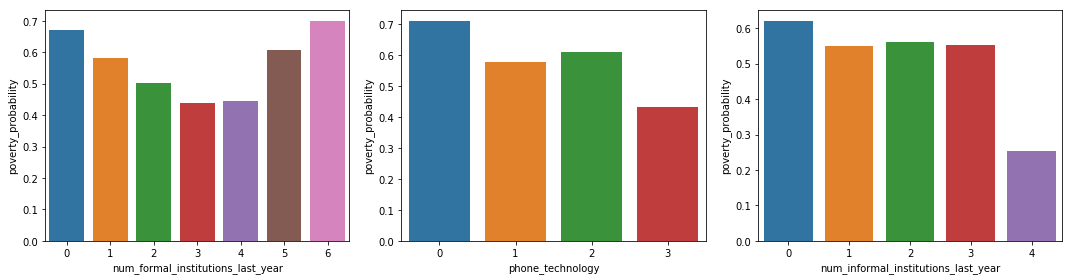

In [104]:
special = ['num_formal_institutions_last_year',
           'phone_technology',
           'num_informal_institutions_last_year']  

fig, axes = plt.subplots(nrows=1, ncols=3, figsize = (15, 4))
for i in range(3):
    col = special[i]
    sns.barplot(x = col, y = 'poverty_probability', data = df, ci = None, ax = axes[i])

plt.tight_layout()  

The cell below recodes these special-case integers as categorical values by converting their values to strings.  

In [105]:
for col in special:
    df[col] = df[col].astype(str)

At this point, a major problem is emerging.  The various issues with the numeric features--being mostly null, being improperly coded, or being uninformative--has left almost no numeric information.  In particular, there are only two floats left ... 

In [124]:
features = df.columns[:-1]
n = len(features)
print('Number of features:', n)
n = (df[features].dtypes == 'float64').sum()
print('Number of floats:', n)
n = (df[features].dtypes == 'int64').sum()
print('Number of integers:', n)

Number of features: 40
Number of floats: 2
Number of integers: 3


... and neither provides much information.

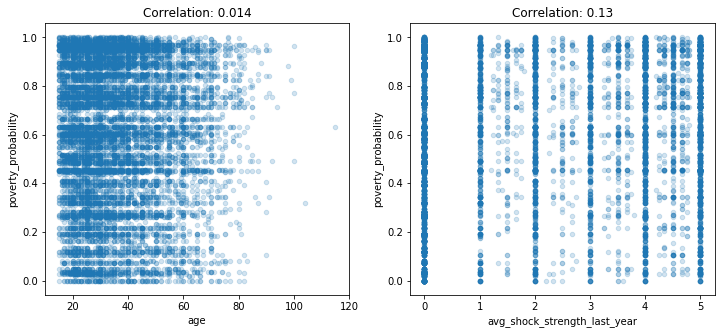

In [107]:
fig, axes = plt.subplots(1,2, figsize = (12,5))
plt.subplots_adjust(hspace=0.5)

columns = ['age', 'avg_shock_strength_last_year']

for i in range(2):
    col = columns[i]
    ax = axes[i]
    df.plot.scatter(x = col, y='poverty_probability', alpha = 0.2, ax = ax)
    corr = df[col].corr(df.poverty_probability).round(3)
    title = 'Correlation: '+str(corr)
    ax.set_title(title)
    
plt.show()

This lack of numeric features is particularly bad for two reasons.  First, numeric features, particularly continuous variables, contain more information, and support regression better than Boolean or categorical features.  Second, having more numeric features enables (more) feature engineering, enabling better predictions.  Here, there is no opportunity to perform feature engineering, at least on a basic level.

## Encoding

The following cells prepare the data for modeling.

In [109]:
import numpy.random as nr
from sklearn import preprocessing, linear_model
from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import r2_score

In [110]:
features = df.columns[:-1]
X = df[features]
y = df.poverty_probability

In [111]:
# Encodes and splits data.  Output: X, y, X2, y2.
%run -i "encode.py"

Encode  ...
Numerics ...
Split ...


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted

The split leaves about 3000 data in the test set.

In [112]:
print('X2 shape:', X2.shape)
print('y2 shape:', y2.shape)

X2 shape: (3017, 104)
y2 shape: (3017,)


# Modeling

The following code will provide standard visualization for the results of applying different models.  Model performance will be judged by the R^2 metric.  (From this point, this notebook will simply denote the metric "R2".)

In [113]:
def scatter(y, yp, title = ''):
    '''
    Justin's scatter for presenting model performance.
    y - true y values.  (Intended for y2.)
    yp - predicted y values.
    ''' 
    plt.figure()
    plt.scatter(y, yp, alpha = .2)
    r2 = r2_score(y, yp).round(3)
    plt.xlabel('poverty_probability')
    plt.ylabel('prediction')
    t = title + '\nR2: '+str(r2)
    plt.title(t)  

`s` will serve as a record for the performance of various models.

In [114]:
results = pd.Series(name = 'R2 Scores')

## Linear Regression

Linear regression does not achieve a high R2 score, generally speaking.  But it will prove difficult to improve much on this model's performance.  In hindsight, we might say that basic linear regression performs well.

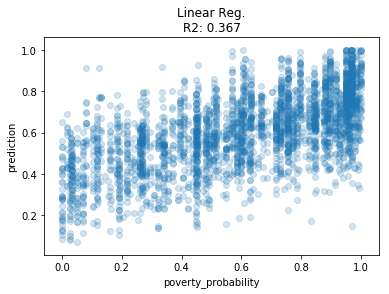

In [115]:
lin_mod = linear_model.LinearRegression()
lin_mod.fit(X, y)
yp = lin_mod.predict(X2)

yp = pd.Series(yp, index = y2.index)
# Linear regression has given a few far-off predictions.
yp = yp.map(lambda x: max(x, 0))
yp = yp.map(lambda x: min(x, 1))

scatter(y2, yp, title = "Linear Reg.")

r2 = r2_score(y2, yp).round(3)
results['Linear Reg.'] = r2

Regularization does not add much in this case.  The cell below performs a hasty parameter sweep for ridge regression.

In [123]:
top_alpha = 0
top_r2 = 0
for alpha in [1, 10, 100, 1000]:
    clf = Ridge(alpha=alpha)
    clf.fit(X, y)
    yp = clf.predict(X2)
    r2 = r2_score(y2, yp).round(3)
    if r2 > top_r2:
        (top_alpha, top_r2) = (alpha, r2)

print('Best alpha:', top_alpha)
print('Best R2:', top_r2)
results['Lin. w Ridge'] = top_r2        

Best alpha: 1
Best R2: 0.367



## Decision Tree Regressor

The cell below tries a Decision Tree Regressor, sweeping across maximum depths.  7 seems to be the ideal depth.  But the decision tree regressor does not outperform linear regression.

Best R2: 0.31


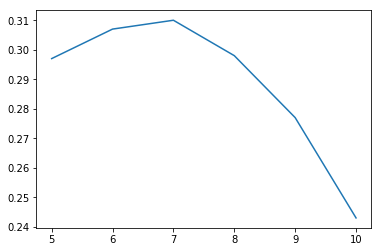

In [117]:
from sklearn.tree import DecisionTreeRegressor
depth_list = [5,6,7,8,9,10, None]
s = pd.Series(name = 'DTR performance')

for depth in depth_list:
    dtr = DecisionTreeRegressor(random_state=0, max_depth = depth)
    dtr.fit(X, y)
    yp = dtr.predict(X2)
    r2 = r2_score(y2, yp).round(3)
    s.loc[depth] = r2

s.plot()   

results['DTR'] = s.max()
print('Best R2:', s.max())

## AdaBoost

The following cell tries AdaBoost with default settings.  AdaBoost performs the worst of the three.

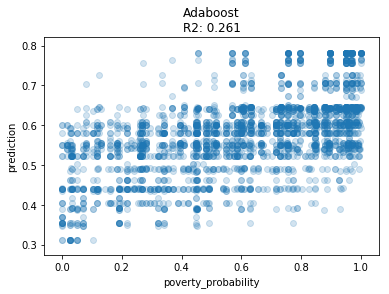

In [118]:
from sklearn.ensemble import AdaBoostRegressor

clf = AdaBoostRegressor(random_state=0)
clf.fit(X, y)  
yp = clf.predict(X2)

yp = pd.Series(yp, index = y2.index)
scatter(y2, yp, title = "Adaboost")

r2 = r2_score(y2, yp).round(3)
results['Adaboost'] = r2

## Results

The performance of these machine learning models is poor all-around, but given the state of the data, this performance is not too surprising.  The most surprising aspect here is that basic linear regression outperformed the more sophisticated models.

In [121]:
results.to_frame()

,R2 Scores
Linear Reg.,0.367
Lin w Ridge,0.367
DTR,0.310
Adaboost,0.261


See the full data report for:
  * Exploration of the features.
  * Commentary on the paucity of numerical features for regression.
  * Performance of the most successful model, the Boosted Decision Tree Regressor (performed in Azure ML Studio).
  * Feature importances, and insights into the PPI.
  